## Evaluate

* Load transferred and untransferred test set
* Load Libraries (we use Bert with pytorch)
* Define Hyperparameters
* Download Preprocessing libraries/vocabularies using nltk

In [83]:
import torch
from matplotlib.pylab import plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from transformers import (
    BertForSequenceClassification,
)

import shared

In [84]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    raise ValueError("Cuda or Apple Metal required but neither is available.")
print(f"Using device: {device}")

Using device: mps


In [85]:
model = BertForSequenceClassification.from_pretrained(
    shared.BERT_MODEL, num_labels=2, output_attentions=False, output_hidden_states=False
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Evaluation

* Evaluate finetuned model on test set

In [86]:
def eval_model(df):
    loader = DataLoader(dataset=df, batch_size=1, shuffle=False)
    model.eval()
    model.load_state_dict(torch.load(shared.model_path, map_location=device))

    score = 0
    pred = []
    gt = []
    for i, (ids, masks, labels) in enumerate(loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]

        pred.append(torch.max(g_labels, 1)[1][0].item())
        gt.append(labels[0].item())

    cm = confusion_matrix(gt, pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.show()

    acc = sum([int(pred[i] == gt[i]) for i in range(len(pred))]) / len(df)
    print(f"Accuracy: {acc:.4f}\n")

In [87]:
test_dataset = torch.load(shared.tokenized_test_dataset_path)

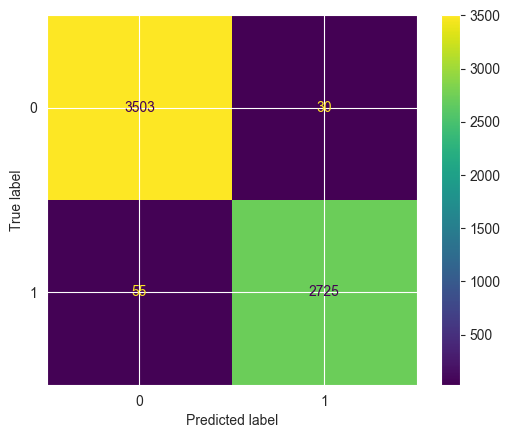

Accuracy: 0.9865


In [88]:
eval_model(test_dataset)

In [89]:
from pathlib import Path

WORKDIR = Path(".")
DATADIR = WORKDIR / "data"
untransferred_fake_testset_path = DATADIR / 'untransferred_fake_testset.pt'
transferred_fake_testset_path = DATADIR / 'transferred_fake_testset.pt'
transferred_fake_csv_path = DATADIR / 'transferred_fake_testset.csv'

untransferred_real_testset_path = DATADIR / 'untransferred_real_testset.pt'
transferred_real_testset_path = DATADIR / 'transferred_real_testset.pt'
transferred_real_csv_path = DATADIR / 'transferred_real_testset.csv'


In [90]:
untransferred_testset_fake = torch.load(untransferred_fake_testset_path)
untransferred_testset_real = torch.load(untransferred_real_testset_path)
transferred_testset_fake = torch.load(transferred_fake_testset_path)
transferred_testset_real = torch.load(transferred_real_testset_path)

Without style transfer fake news:


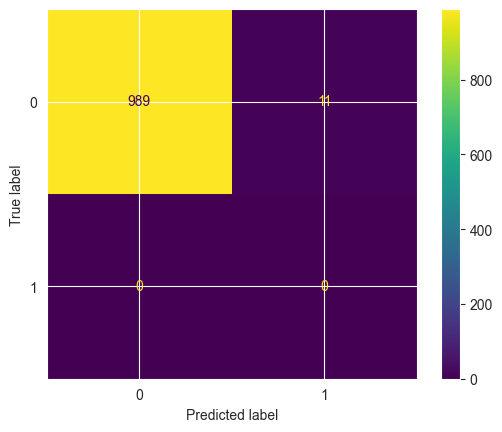

Accuracy: 0.9890


In [91]:
print("Without style transfer fake news:\n")
eval_model(untransferred_testset_fake)

With style transfer fake news:


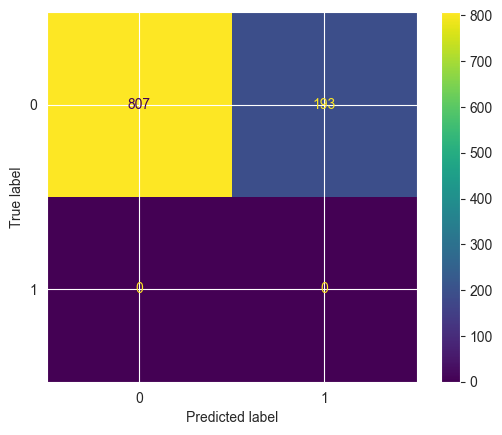

Accuracy: 0.8070


In [97]:
print("With style transfer fake news:\n")
eval_model(transferred_testset_fake)

Without style transfer real news:


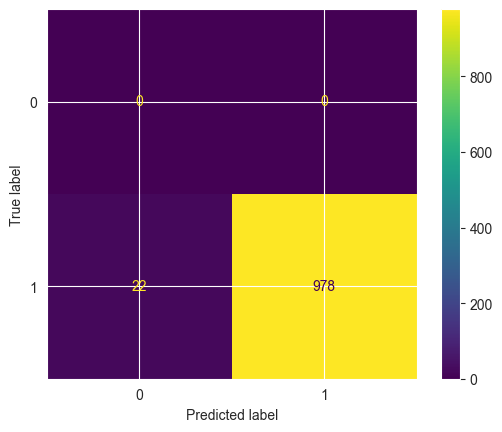

Accuracy: 0.9780


In [95]:
print("Without style transfer real news:\n")
eval_model(untransferred_testset_real)

With style transfer real news:


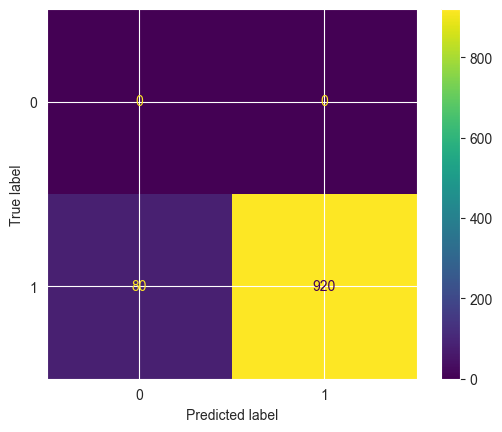

Accuracy: 0.9200


In [96]:
print("With style transfer real news:\n")
eval_model(transferred_testset_real)